In [48]:
import pandas as pd

hall_df = pd.read_csv("chair-med/hallucinated_labels.csv")
gen_df = pd.read_csv("chair-med/gen_labels.csv")

In [5]:
def calculate_coscores(df):
    # Convert DataFrame to boolean type to ensure True/False values
    df = df.astype(bool)
    
    # Get all column pairs
    columns = df.columns
    n_cols = len(columns)
    
    # Calculate individual occurrence counts for each column
    individual_counts = {col: df[col].sum() for col in columns}
    
    # Calculate co-occurrence counts for all pairs
    pair_counts = {}
    for i in range(n_cols):
        for j in range(i+1, n_cols):
            col1, col2 = columns[i], columns[j]
            pair_counts[(col1, col2)] = (df[col1] & df[col2]).sum()
    
    # Calculate CoScore for each row
    coscores = []
    for _, row in df.iterrows():
        score = 0
        true_cols = row[row].index  # Get columns that are True for this row
        
        if len(true_cols) <= 1:
            coscores.append(0)
            continue
        
        # For each pair of True columns
        for i in range(len(true_cols)):
            for j in range(i+1, len(true_cols)):
                col1, col2 = true_cols[i], true_cols[j]
                
                # Get pair count (ensure order doesn't matter)
                pair_key = (col1, col2) if (col1, col2) in pair_counts else (col2, col1)
                pair_count = pair_counts[pair_key]
                
                # Calculate normalized score for this pair
                normalized_score = pair_count / (individual_counts[col1] + individual_counts[col2])
                score += normalized_score
                
        coscores.append(score)
    
    return pd.Series(coscores)

Mean CoScore for hallucinated labels: 32.35070773464403
Standard deviation of CoScore for hallucinated labels: 6.630031200362316
Mean CoScore for non-hallucinated labels: 29.894480407622645
Standard deviation of CoScore for non-hallucinated labels: 7.572364155301909


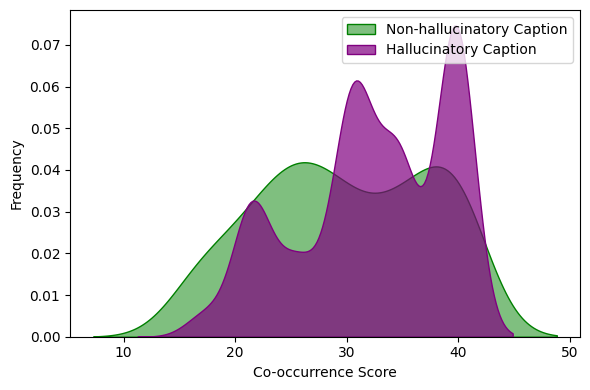

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_coscore_statistics(gen_df, hall_df):
    coscores = calculate_coscores(gen_df)
    # Create a series indicating if each row has any True values
    has_hallucination = hall_df.any(axis=1)

    # Separate hallucinated and non-hallucinated reports based on has_hallucination
    hall_coscores = coscores[has_hallucination]
    non_hall_coscores = coscores[~has_hallucination]

    print(f"Mean CoScore for hallucinated labels: {hall_coscores.mean()}")
    print(f"Standard deviation of CoScore for hallucinated labels: {hall_coscores.std()}")

    print(f"Mean CoScore for non-hallucinated labels: {non_hall_coscores.mean()}")
    print(f"Standard deviation of CoScore for non-hallucinated labels: {non_hall_coscores.std()}")
    
    return hall_coscores, non_hall_coscores

def plot_coscore_distributions(hall_coscores, non_hall_coscores):
    plt.figure(figsize=(6, 4))

    # Plotting KDE for non-hallucinatory captions
    sns.kdeplot(non_hall_coscores, fill=True, color='green', alpha=0.5, label='Non-hallucinatory Caption')

    # Plotting KDE for hallucinatory captions 
    sns.kdeplot(hall_coscores, fill=True, color='purple', alpha=0.7, label='Hallucinatory Caption')

    plt.xlabel('Co-occurrence Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function with the existing data
hall_coscores, non_hall_coscores = analyze_coscore_statistics(gen_df, hall_df)
plot_coscore_distributions(hall_coscores, non_hall_coscores)


In [15]:
# Read the CSV file without any predefined columns
gn_reports = pd.read_csv('chair-med/gn_reports.csv', header=None).squeeze("columns")
gn_positions = pd.read_csv('chair-med/generated_positions.csv')
non_hall_df = pd.read_csv('chair-med/non_hallucinated_labels.csv')

In [20]:
def calculate_position_ratios(hall_positions, reports):
    position_ratios = []
    for idx, row in hall_positions.iterrows():
        for col_name, value in row.items():
            if col_name != 'No Finding' and pd.notna(value) and value != -1:
                report_length = len(reports[idx])
                position_ratios.append(value / report_length)
    
    return position_ratios

Number of position ratios calculated for hallucinated labels: 2101
Mean position ratio for hallucinated labels: 0.469
Standard deviation of position ratios for hallucinated labels: 0.212
Number of position ratios calculated for non-hallucinated labels: 817
Mean position ratio for non-hallucinated labels: 0.487
Standard deviation of position ratios for non-hallucinated labels: 0.224


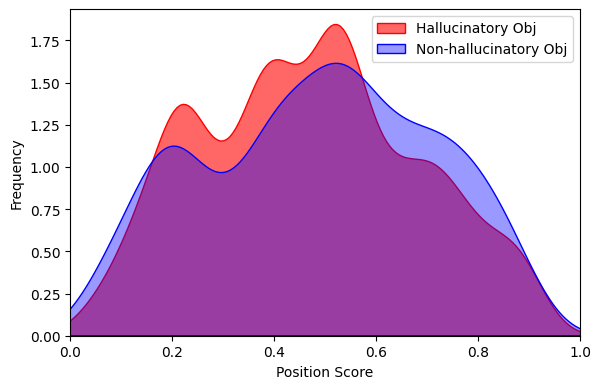

In [33]:
import numpy as np

def analyze_position_statistics(gn_positions, hall_df, non_hall_df, gn_reports):
    hall_positions = gn_positions.where(hall_df)
    non_hall_positions = gn_positions.where(non_hall_df)

    hall_position_ratios = calculate_position_ratios(hall_positions, gn_reports)
    non_hall_position_ratios = calculate_position_ratios(non_hall_positions, gn_reports)

    print(f"Number of position ratios calculated for hallucinated labels: {len(hall_position_ratios)}")
    print(f"Mean position ratio for hallucinated labels: {np.mean(hall_position_ratios):.3f}")
    print(f"Standard deviation of position ratios for hallucinated labels: {np.std(hall_position_ratios):.3f}")

    print(f"Number of position ratios calculated for non-hallucinated labels: {len(non_hall_position_ratios)}")
    print(f"Mean position ratio for non-hallucinated labels: {np.mean(non_hall_position_ratios):.3f}")
    print(f"Standard deviation of position ratios for non-hallucinated labels: {np.std(non_hall_position_ratios):.3f}")
    
    return hall_position_ratios, non_hall_position_ratios


def plot_position_ratio_distributions(hall_position_ratios, non_hall_position_ratios):
    plt.figure(figsize=(6, 4))
    
    sns.kdeplot(hall_position_ratios, fill=True, color='red', label='Hallucinatory Obj', alpha=0.6)
    sns.kdeplot(non_hall_position_ratios, fill=True, color='blue', label='Non-hallucinatory Obj', alpha=0.4)
    
    plt.xlabel("Position Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.xlim(0, 1)
    plt.show()

hall_position_ratios, non_hall_position_ratios = analyze_position_statistics(gn_positions, hall_df, non_hall_df, gn_reports)
plot_position_ratio_distributions(hall_position_ratios, non_hall_position_ratios)

In [34]:
def calculate_hallucination_rates(hall_df, non_hall_df):
    hall_rates = {}
    for col in hall_df.columns:
        total = (hall_df[col] | non_hall_df[col]).sum()
        if total > 0:
            hall_rate = hall_df[col].sum() / total
            hall_rates[col] = hall_rate

    sorted_rates = dict(sorted(hall_rates.items(), key=lambda x: x[1], reverse=True))

    print("\nHallucination rates by condition:")
    for condition, rate in sorted_rates.items():
        print(f"{condition}: {rate:.3f}")

    print(f"\nMean hallucination rate across all conditions: {np.mean(list(hall_rates.values())):.3f}")
    
    return hall_rates, sorted_rates

hall_rates, sorted_rates = calculate_hallucination_rates(hall_df, non_hall_df)



Hallucination rates by condition:
Fracture: 1.000
Lung Lesion: 0.962
Enlarged Cardiomediastinum: 0.919
Consolidation: 0.877
Pneumothorax: 0.859
Pneumonia: 0.856
Pleural Other: 0.833
Lung Opacity: 0.746
Cardiomegaly: 0.740
Atelectasis: 0.694
Edema: 0.625
No Finding: 0.547
Support Devices: 0.539
Pleural Effusion: 0.470

Mean hallucination rate across all conditions: 0.762


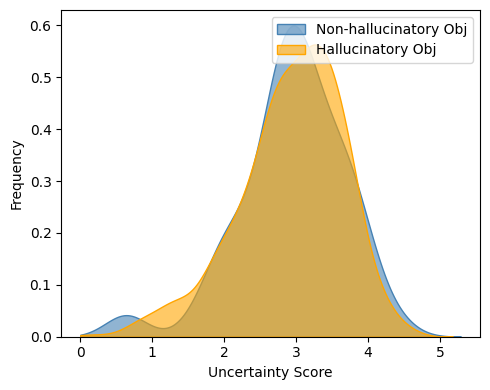

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

clip_df = pd.read_csv("clip_results.csv", nrows=1000)[[
    'highest_sim_score', 'actual_pair_sim', 
    'highest_raw_sim_score', 'actual_pair_raw_sim'
]]

clip_df['highest_sim_score_neg_log'] = -np.log(clip_df['highest_sim_score'])

has_hallucination = hall_df.any(axis=1)
clip_hall_df = clip_df[has_hallucination]
clip_non_hall_df = clip_df[~has_hallucination]

# Plot
plt.figure(figsize=(5, 4))
sns.kdeplot(clip_non_hall_df['highest_sim_score_neg_log'], fill=True, label="Non-hallucinatory Obj", color='steelblue', alpha=0.6, clip=(0, None))
sns.kdeplot(clip_hall_df['highest_sim_score_neg_log'], fill=True, label="Hallucinatory Obj", color='orange', alpha=0.6, clip=(0, None))

plt.xlabel("Uncertainty Score")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


Mean CoScore for hallucinated labels: 0.46040440296649177
Standard deviation of CoScore for hallucinated labels: 0.65610862787067
Mean CoScore for non-hallucinated labels: 0.027895868847822948
Standard deviation of CoScore for non-hallucinated labels: 0.08250171940900576


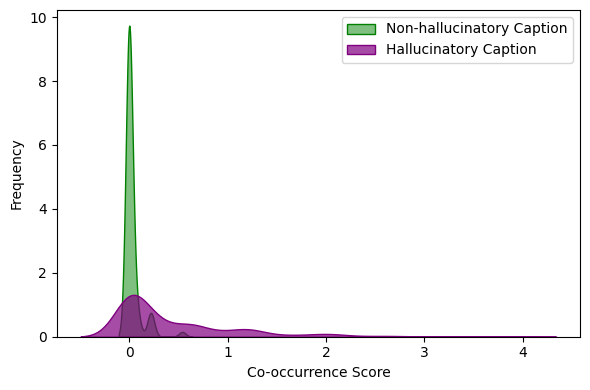

In [37]:
import pandas as pd

hall_lvlm_df = pd.read_csv("results/chexagent/hallucinated_labels.csv", index_col=0)
gen_lvlm_df = pd.read_csv("results/chexagent/lvlm_labels.csv", index_col=0)
hall_coscores, non_hall_coscores = analyze_coscore_statistics(gen_lvlm_df, hall_lvlm_df)
plot_coscore_distributions(hall_coscores, non_hall_coscores)

In [43]:
(hall_lvlm_df.sum(axis=1) > 0).sum() / len(hall_lvlm_df)

0.9306569343065694

In [44]:
# Calculate total number of True values in hallucinated and generated labels
hall_true_count = hall_lvlm_df.values.sum()
gen_true_count = gen_lvlm_df.values.sum()

# Calculate ratio of hallucinated to generated True values
hall_to_gen_ratio = hall_true_count / gen_true_count
print(f"Ratio of hallucinated to generated True values: {hall_to_gen_ratio:.3f}")


Ratio of hallucinated to generated True values: 0.803


In [51]:
# Calculate total number of True values in hallucinated and generated labels
hall_true_count = hall_df.values.sum()
gen_true_count = ((gen_df.values == 1.0) | (gen_df.values == -1.0)).sum()

# Calculate ratio of hallucinated to generated True values
hall_to_gen_ratio = hall_true_count / gen_true_count
print(f"Ratio of hallucinated to generated True values: {hall_to_gen_ratio:.3f}")


Ratio of hallucinated to generated True values: 0.717
